In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from dask import compute, delayed

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(10)

In [4]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

<Client: 'tcp://10.148.0.250:42597' processes=14 threads=14, memory=223.58 GiB>

_________
# 1. Read dataset


In [ ]:
out_dir_zarr = '/home/datawork-lops-osi/equinox/mit4320/zarr/'
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/TAU/'

# read rechunked data
grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
ds_TAUX = xr.open_zarr(out_dir_zarr+'oceTAUX.zarr').rename({'i_g': 'i'}).isel(time=slice(0,None,24))
ds_TAUY = xr.open_zarr(out_dir_zarr+'oceTAUY.zarr').rename({'j_g': 'j'}).isel(time=slice(0,None,24))

# data merge
ds = xr.merge([ds_TAUX,ds_TAUY,grid])
print(ds)

In [7]:
# coriolis term
lat = ds['YC']
omega = 7.3/100000
f_ij = 2*omega*np.sin(np.deg2rad(lat))
f_ij

<xarray.DataArray 'YC' (face: 13, j: 4320, i: 4320)>
dask.array<mul, shape=(13, 4320, 4320), dtype=float32, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

In [ ]:
# Ekman layer depth
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = store_dir_zarr+'ELD_daily_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:
        
        oceTAUX_rotation =  ds.oceTAUX.isel(face=face)*ds.CS.isel(face=face) - ds.oceTAUY.isel(face=face)*ds.SN.isel(face=face)
        oceTAUY_rotation =  ds.oceTAUX.isel(face=face)*ds.SN.isel(face=face) + ds.oceTAUY.isel(face=face)*ds.CS.isel(face=face)
        ELD = 0.2*np.sqrt(np.sqrt(oceTAUX_rotation**2 + oceTAUY_rotation**2)/1025)/np.abs(f_ij.isel(face=face))
        ELD = ELD.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))
        chunks = {'i': 1080, 'j': 1080}
        ELD = ELD.chunk(chunks)
        
        # store
        ELD = np.real(ELD).rename('ELD')
        ELD = ELD.to_dataset()
        
        for c in ELD.coords:
            try:
                del E[c].encoding['chunks']
            except:
                pass        
        
        %time ELD.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

In [7]:
# Tau_x/ELD/Rho (i.e. vertical momentum flux in zonnal direction)
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = store_dir_zarr+'TAUX_ELD_rotation_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:
        
        oceTAUX_rotation =  ds.oceTAUX.isel(face=face)*ds.CS.isel(face=face) - ds.oceTAUY.isel(face=face)*ds.SN.isel(face=face)
        oceTAUY_rotation =  ds.oceTAUX.isel(face=face)*ds.SN.isel(face=face) + ds.oceTAUY.isel(face=face)*ds.CS.isel(face=face)
        ELD = 0.2*np.sqrt(np.sqrt(oceTAUX_rotation**2 + oceTAUY_rotation**2)/1025)/np.abs(f_ij.isel(face=face))
        oceTAUX_H =  oceTAUX_rotation.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/ELD.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/1025
        chunks = {'i': 1080, 'j': 1080}
        oceTAUX_H = oceTAUX_H.chunk(chunks)
        
        # store
        oceTAUX_H = np.real(oceTAUX_H).rename('oceTAUX_H')
        oceTAUX_H = oceTAUX_H.to_dataset()
        
        for c in oceTAUX_H.coords:
            try:
                del E[c].encoding['chunks']
            except:
                pass        
        
        %time oceTAUX_H.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

CPU times: user 1.39 s, sys: 128 ms, total: 1.52 s
Wall time: 15.8 s
--- face 0 done
CPU times: user 1.31 s, sys: 84 ms, total: 1.39 s
Wall time: 9.53 s
--- face 1 done
CPU times: user 1.28 s, sys: 108 ms, total: 1.39 s
Wall time: 8.31 s
--- face 2 done
CPU times: user 1.18 s, sys: 116 ms, total: 1.3 s
Wall time: 7.45 s
--- face 3 done
CPU times: user 1.27 s, sys: 112 ms, total: 1.38 s
Wall time: 8.9 s
--- face 4 done
CPU times: user 1.18 s, sys: 108 ms, total: 1.29 s
Wall time: 7.87 s
--- face 5 done
CPU times: user 1.48 s, sys: 124 ms, total: 1.61 s
Wall time: 9.41 s
--- face 6 done
CPU times: user 1.24 s, sys: 124 ms, total: 1.37 s
Wall time: 8.25 s
--- face 7 done
CPU times: user 1.35 s, sys: 76 ms, total: 1.42 s
Wall time: 9.43 s
--- face 8 done
CPU times: user 1.22 s, sys: 168 ms, total: 1.39 s
Wall time: 9.1 s
--- face 9 done
CPU times: user 1.22 s, sys: 84 ms, total: 1.3 s
Wall time: 7.42 s
--- face 10 done
CPU times: user 1.26 s, sys: 104 ms, total: 1.36 s
Wall time: 8.35 s
--

In [13]:
# Tau_y/ELD/Rho (i.e. vertical momentum flux in meridional direction)
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = store_dir_zarr+'TAUY_ELD_rotation_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:
        
        oceTAUX_rotation =  ds.oceTAUX.isel(face=face)*ds.CS.isel(face=face) - ds.oceTAUY.isel(face=face)*ds.SN.isel(face=face)
        oceTAUY_rotation =  ds.oceTAUX.isel(face=face)*ds.SN.isel(face=face) + ds.oceTAUY.isel(face=face)*ds.CS.isel(face=face)
        ELD = 0.2*np.sqrt(np.sqrt(oceTAUX_rotation**2 + oceTAUY_rotation**2)/1025)/np.abs(f_ij.isel(face=face))
        oceTAUY_H =  oceTAUY_rotation.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/ELD.isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/1025
        chunks = {'i': 1080, 'j': 1080}
        oceTAUY_H = oceTAUY_H.chunk(chunks)
        
        # store
        oceTAUY_H = np.real(oceTAUY_H).rename('oceTAUY_H')
        oceTAUY_H = oceTAUY_H.to_dataset()
        
        for c in oceTAUY_H.coords:
            try:
                del E[c].encoding['chunks']
            except:
                pass        
        
        %time oceTAUY_H.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

CPU times: user 1.22 s, sys: 116 ms, total: 1.33 s
Wall time: 7.78 s
--- face 0 done
CPU times: user 1.24 s, sys: 116 ms, total: 1.36 s
Wall time: 9.03 s
--- face 1 done
CPU times: user 1.28 s, sys: 76 ms, total: 1.36 s
Wall time: 8.19 s
--- face 2 done
CPU times: user 1.26 s, sys: 80 ms, total: 1.34 s
Wall time: 7.64 s
--- face 3 done
CPU times: user 1.28 s, sys: 100 ms, total: 1.38 s
Wall time: 8.63 s
--- face 4 done
CPU times: user 1.24 s, sys: 68 ms, total: 1.3 s
Wall time: 6.94 s
--- face 5 done
CPU times: user 1.22 s, sys: 124 ms, total: 1.35 s
Wall time: 7.97 s
--- face 6 done
CPU times: user 1.21 s, sys: 152 ms, total: 1.36 s
Wall time: 8.11 s
--- face 7 done
CPU times: user 1.34 s, sys: 84 ms, total: 1.43 s
Wall time: 9.31 s
--- face 8 done
CPU times: user 1.21 s, sys: 132 ms, total: 1.34 s
Wall time: 7.94 s
--- face 9 done
CPU times: user 1.26 s, sys: 104 ms, total: 1.36 s
Wall time: 8.29 s
--- face 10 done
CPU times: user 1.24 s, sys: 132 ms, total: 1.38 s
Wall time: 8.26 s


# Results

In [5]:
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/TAU/'
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

D = [xr.open_zarr(store_dir_zarr+'TAUX_ELD_rotation_f%02d.zarr'%(face)) for face in face_all] 
ds_TAUX_ELD_rotation = xr.concat(D, dim='face')

D = [xr.open_zarr(store_dir_zarr+'TAUY_ELD_rotation_f%02d.zarr'%(face)) for face in face_all] 
ds_TAUY_ELD_rotation = xr.concat(D, dim='face')

D = [xr.open_zarr(store_dir_zarr+'ELD_f%02d.zarr'%(face)) for face in face_all] 
ds_ELD = xr.concat(D, dim='face')

In [16]:
out_dir_zarr = '/home/datawork-lops-osi/equinox/mit4320/zarr/'
ice = xr.open_zarr(out_dir_zarr+'sea_ice_mask.zarr').isel(j=slice(0 ,None, 4), i=slice(0, None, 4))
ice

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
Data variables:
    AREA     (face, j, i) float64 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

In [7]:
def quick_llc_plot(data, axis_off=False, **kwargs):
    face_to_axis = {0: (2, 0), 1: (1, 0), 2: (0, 0),
                    3: (2, 1), 4: (1, 1), 5: (0, 1),
                    7: (0, 2), 8: (1, 2), 9: (2, 2),
                    10: (0, 3), 11: (1, 3), 12: (2, 3)}
    transpose = [7, 8, 9, 10, 11, 12]
    gridspec_kw = dict(left=0, bottom=0, right=4, top=4, wspace=0, hspace=0)
    fig, axes = plt.subplots(nrows=3, ncols=4, gridspec_kw=gridspec_kw)
    for face, (j, i) in face_to_axis.items():
        data_ax = data.isel(face=face)
        ax = axes[j,i]
        yincrease = True
        if face in transpose:
            data_ax = data_ax.transpose()
            yincrease = False
        data_ax.plot(ax=ax, yincrease=yincrease, **kwargs)
        if axis_off:
            ax.axis('off')
        ax.set_title('')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

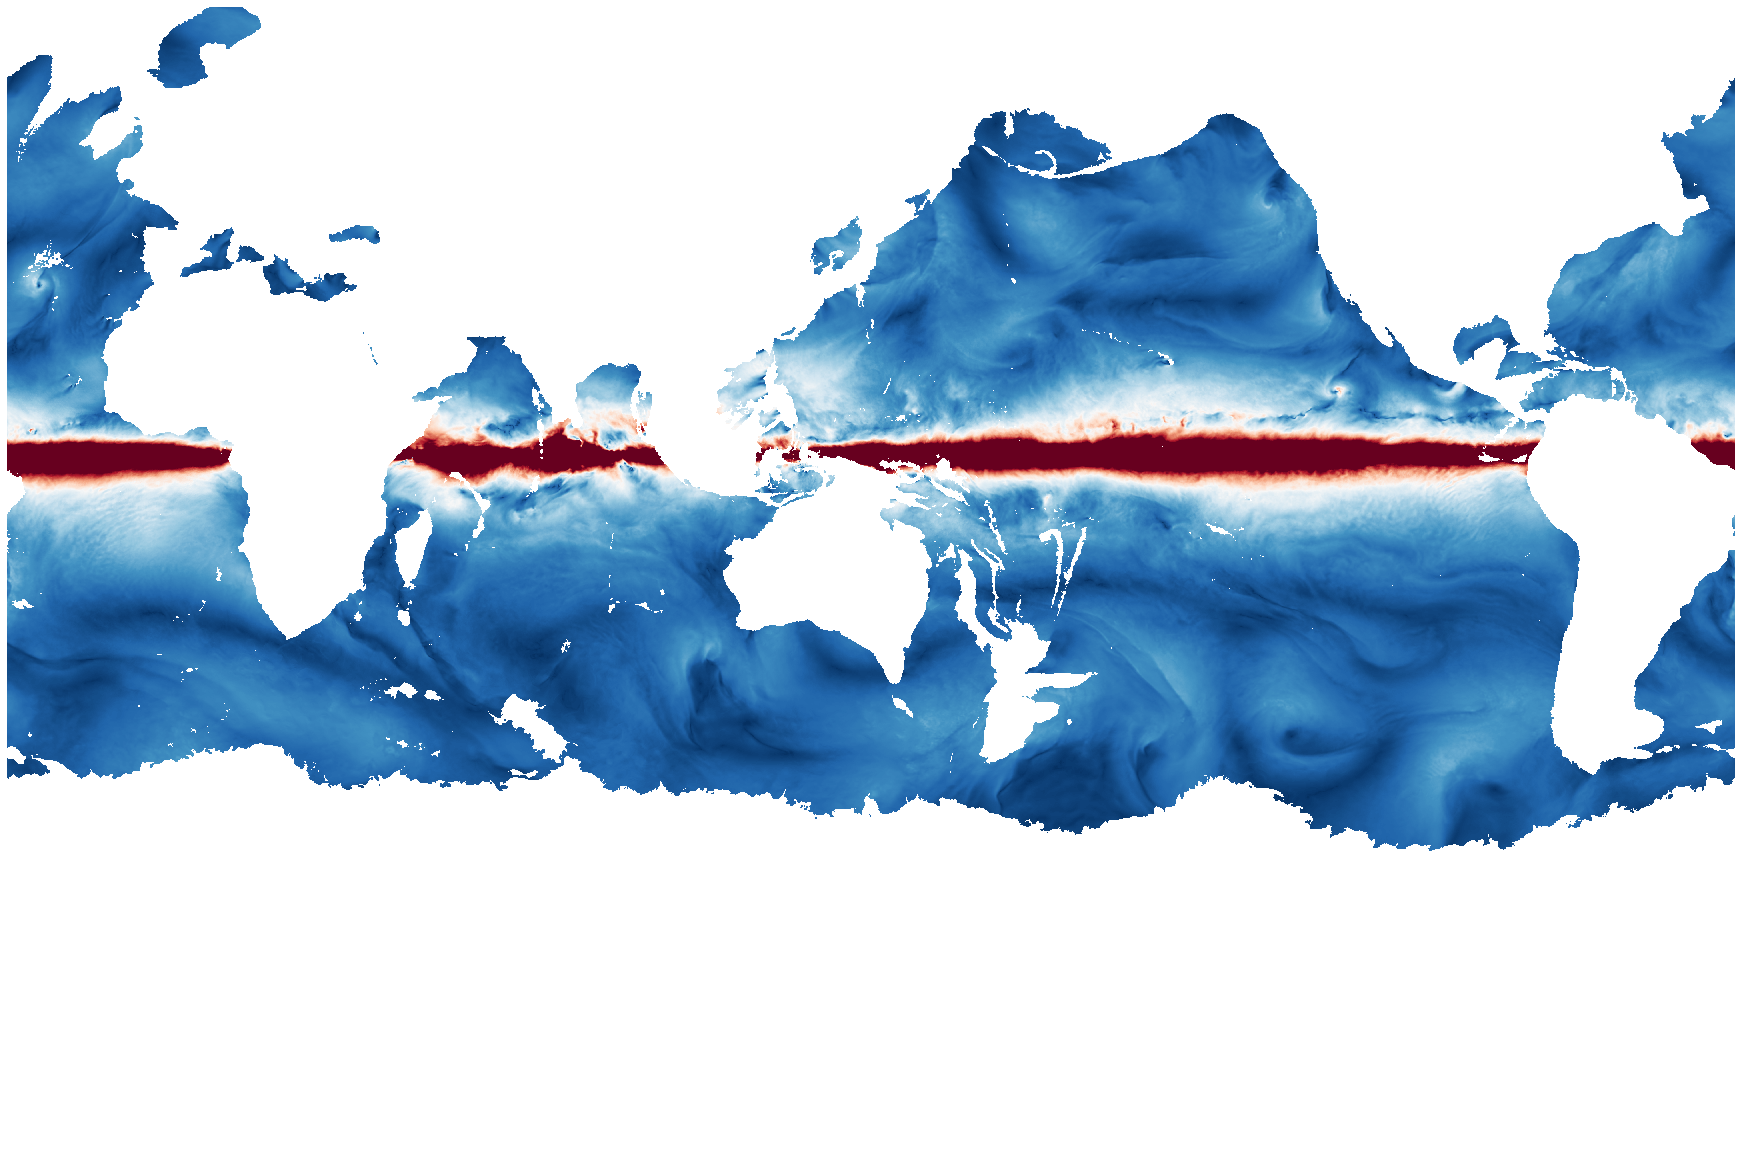

In [18]:
quick_llc_plot(ds_ELD.ELD.sel(time='2011-11-24T08:00:00').where( (ice.AREA>0)&(ds_ELD.Depth>2000) ), vmin=0, vmax=200, add_colorbar=False, axis_off=True, cmap = 'RdBu_r')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

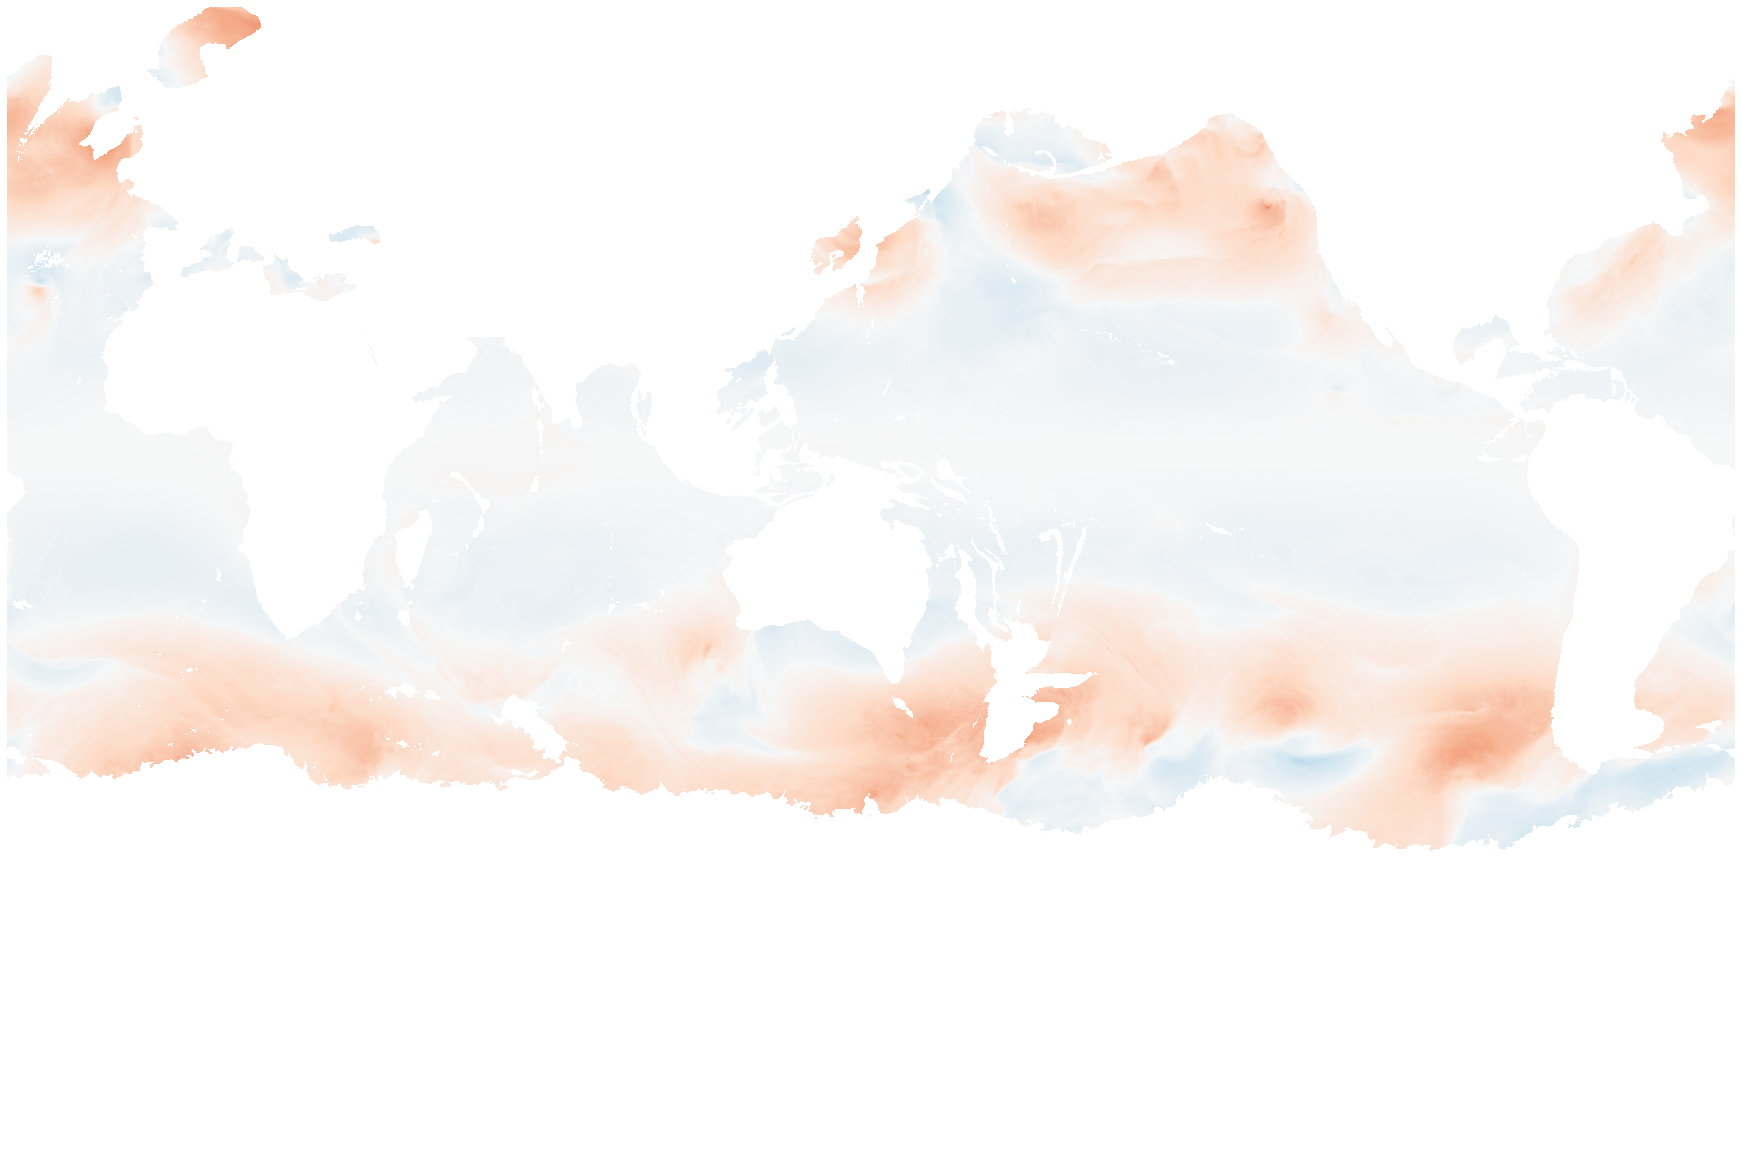

In [19]:
quick_llc_plot(ds_TAUX_ELD_rotation.oceTAUX_H.sel(time='2011-11-24T08:00:00').where( (ice.AREA>0)&(ds_ELD.Depth>2000) ), vmin=-4e-5, vmax=4e-5, add_colorbar=False, axis_off=True, cmap = 'RdBu_r')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

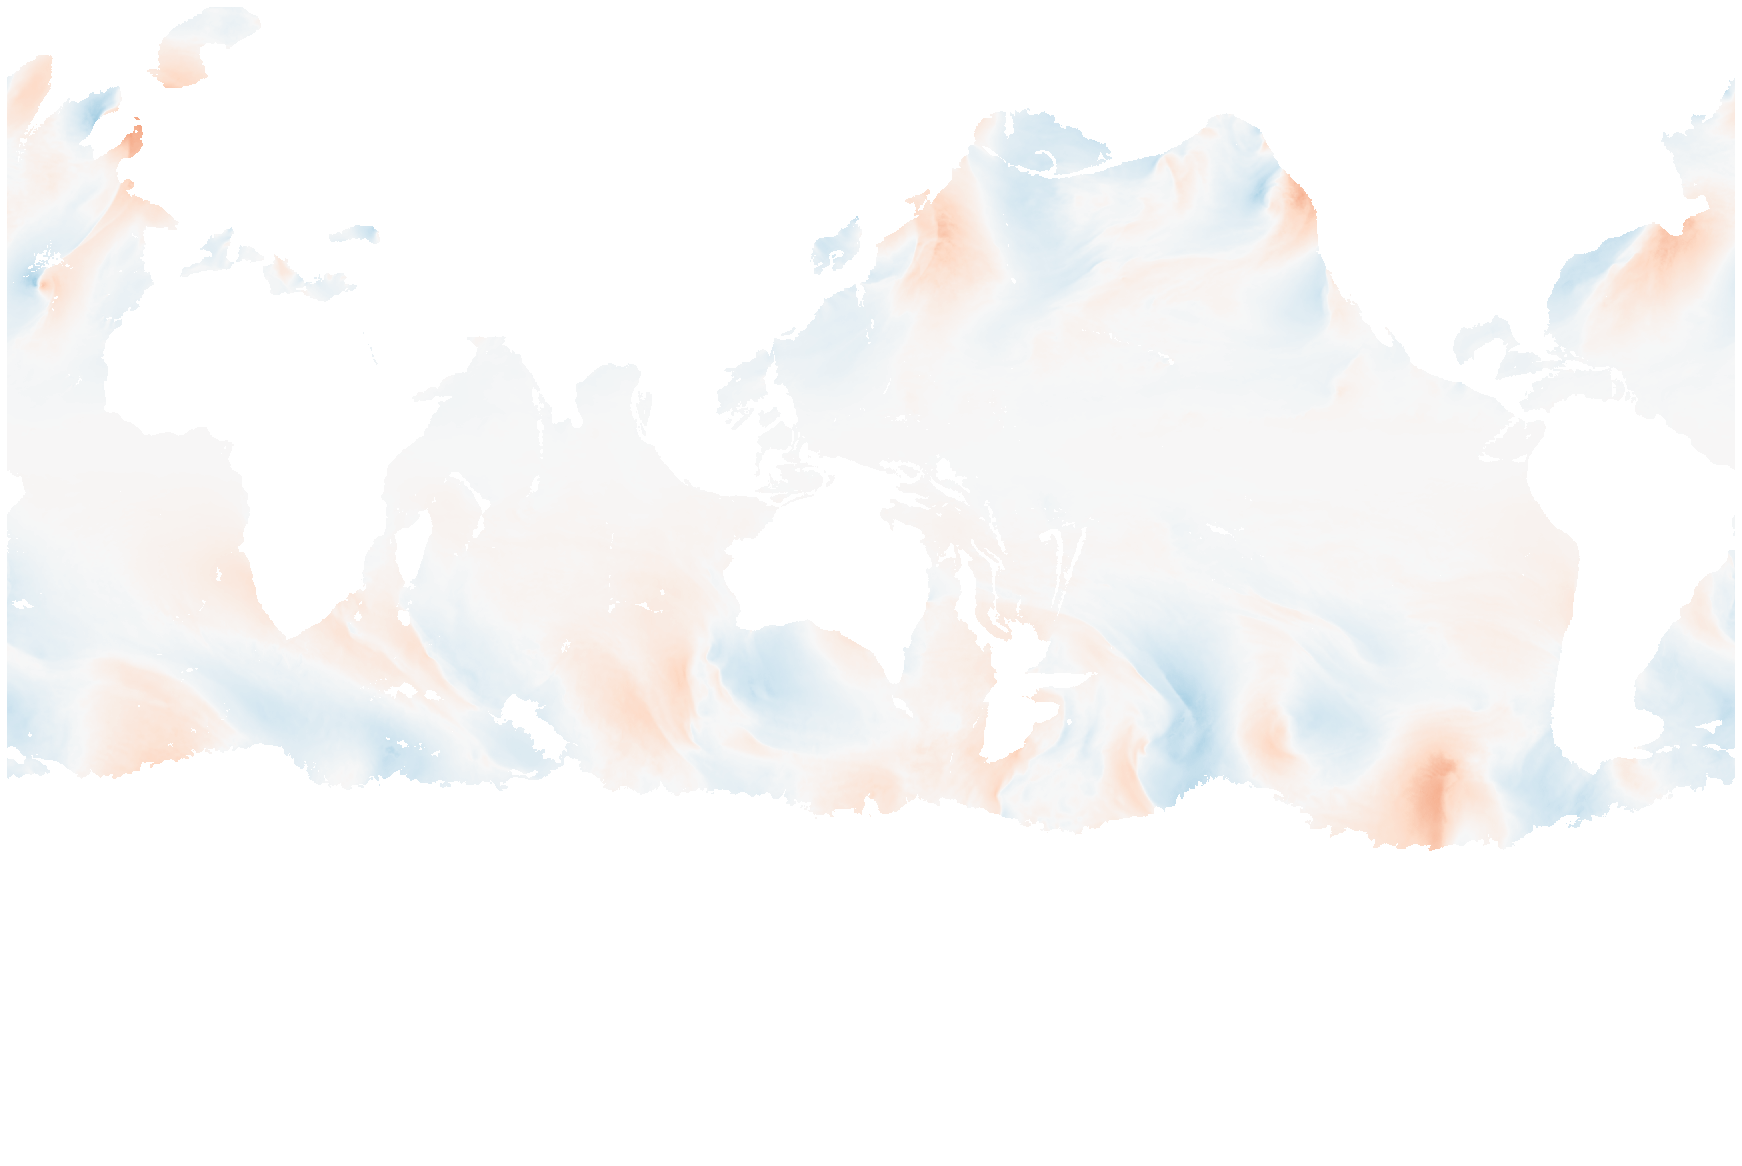

In [20]:
quick_llc_plot(ds_TAUY_ELD_rotation.oceTAUY_H.sel(time='2011-11-24T08:00:00').where( (ice.AREA>0)&(ds_ELD.Depth>2000) ), vmin=-4e-5, vmax=4e-5, add_colorbar=False, axis_off=True, cmap = 'RdBu_r')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

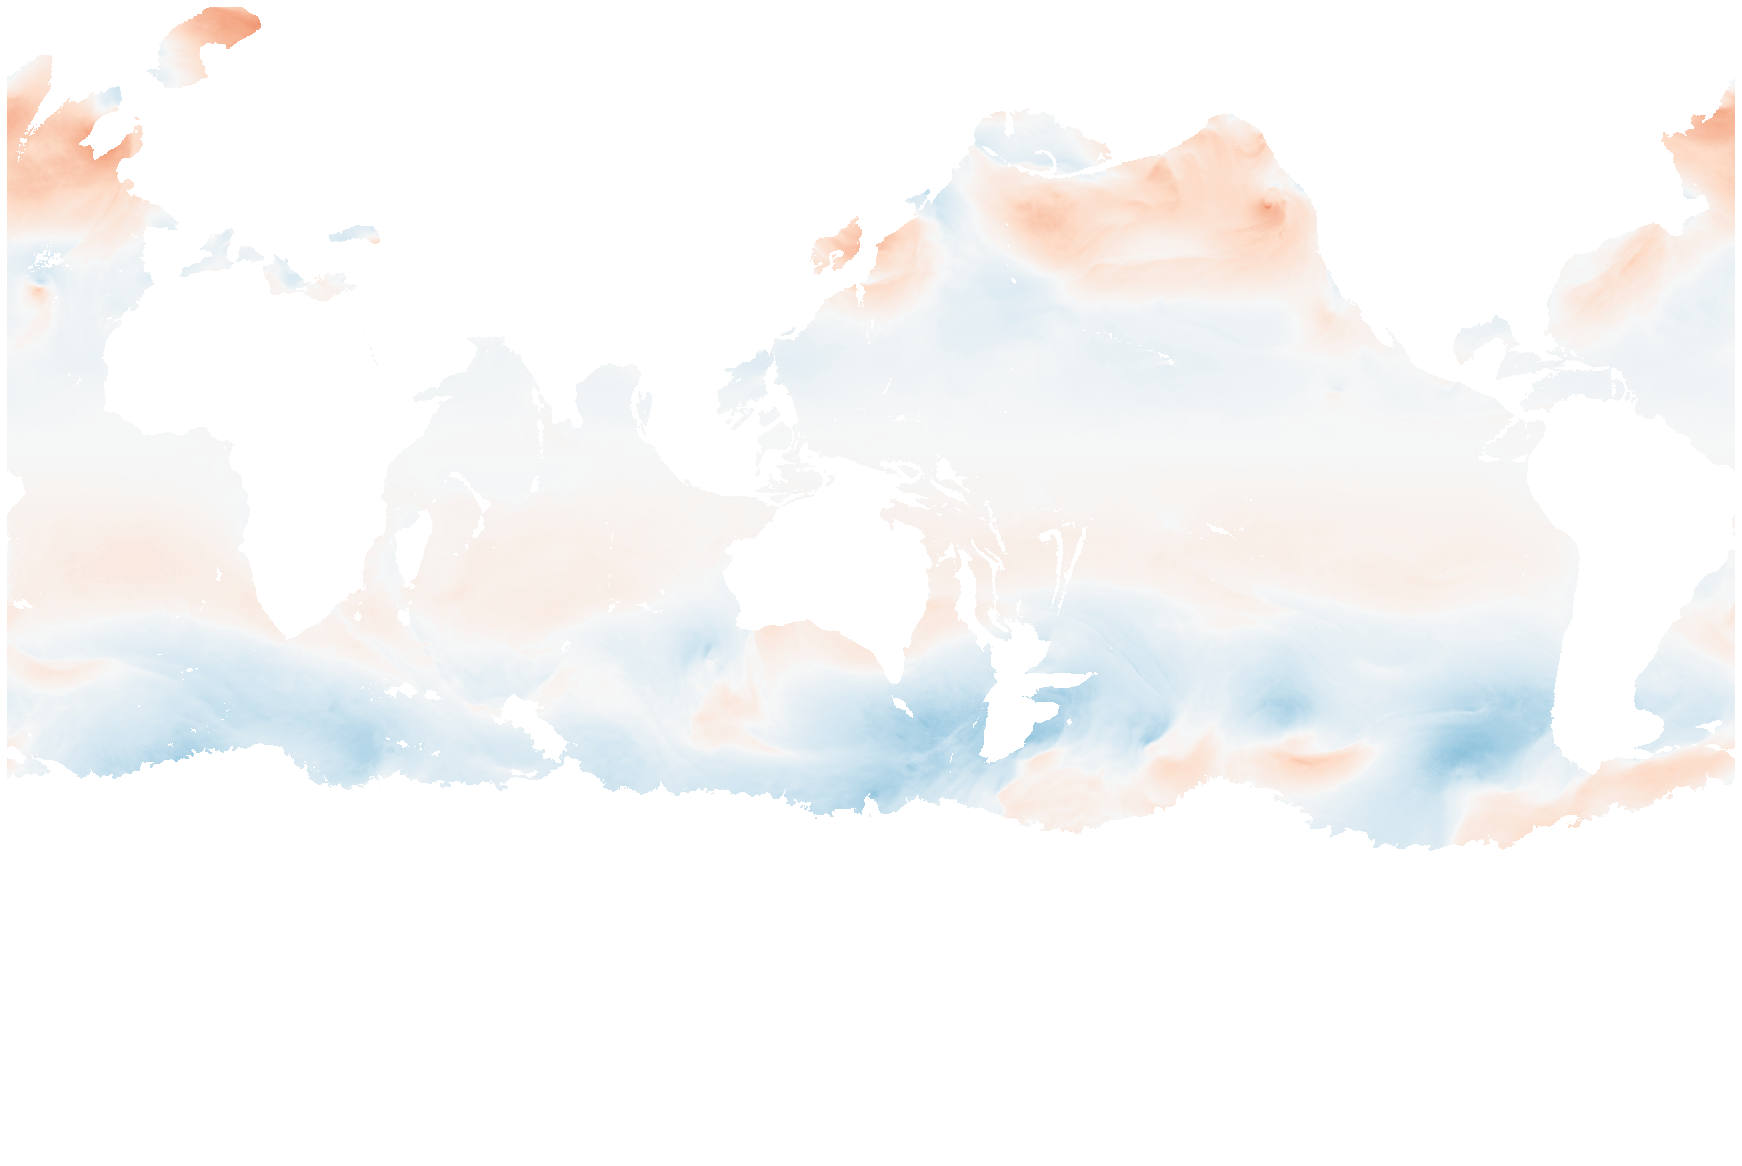

In [21]:
quick_llc_plot(ds_TAUX_ELD_rotation.oceTAUX_H.sel(time='2011-11-24T08:00:00')*(f_ij)/np.abs(f_ij).where( (ice.AREA>0)&(ds_ELD.Depth>2000) ), vmin=-4e-5, vmax=4e-5, add_colorbar=False, axis_off=True, cmap = 'RdBu_r')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

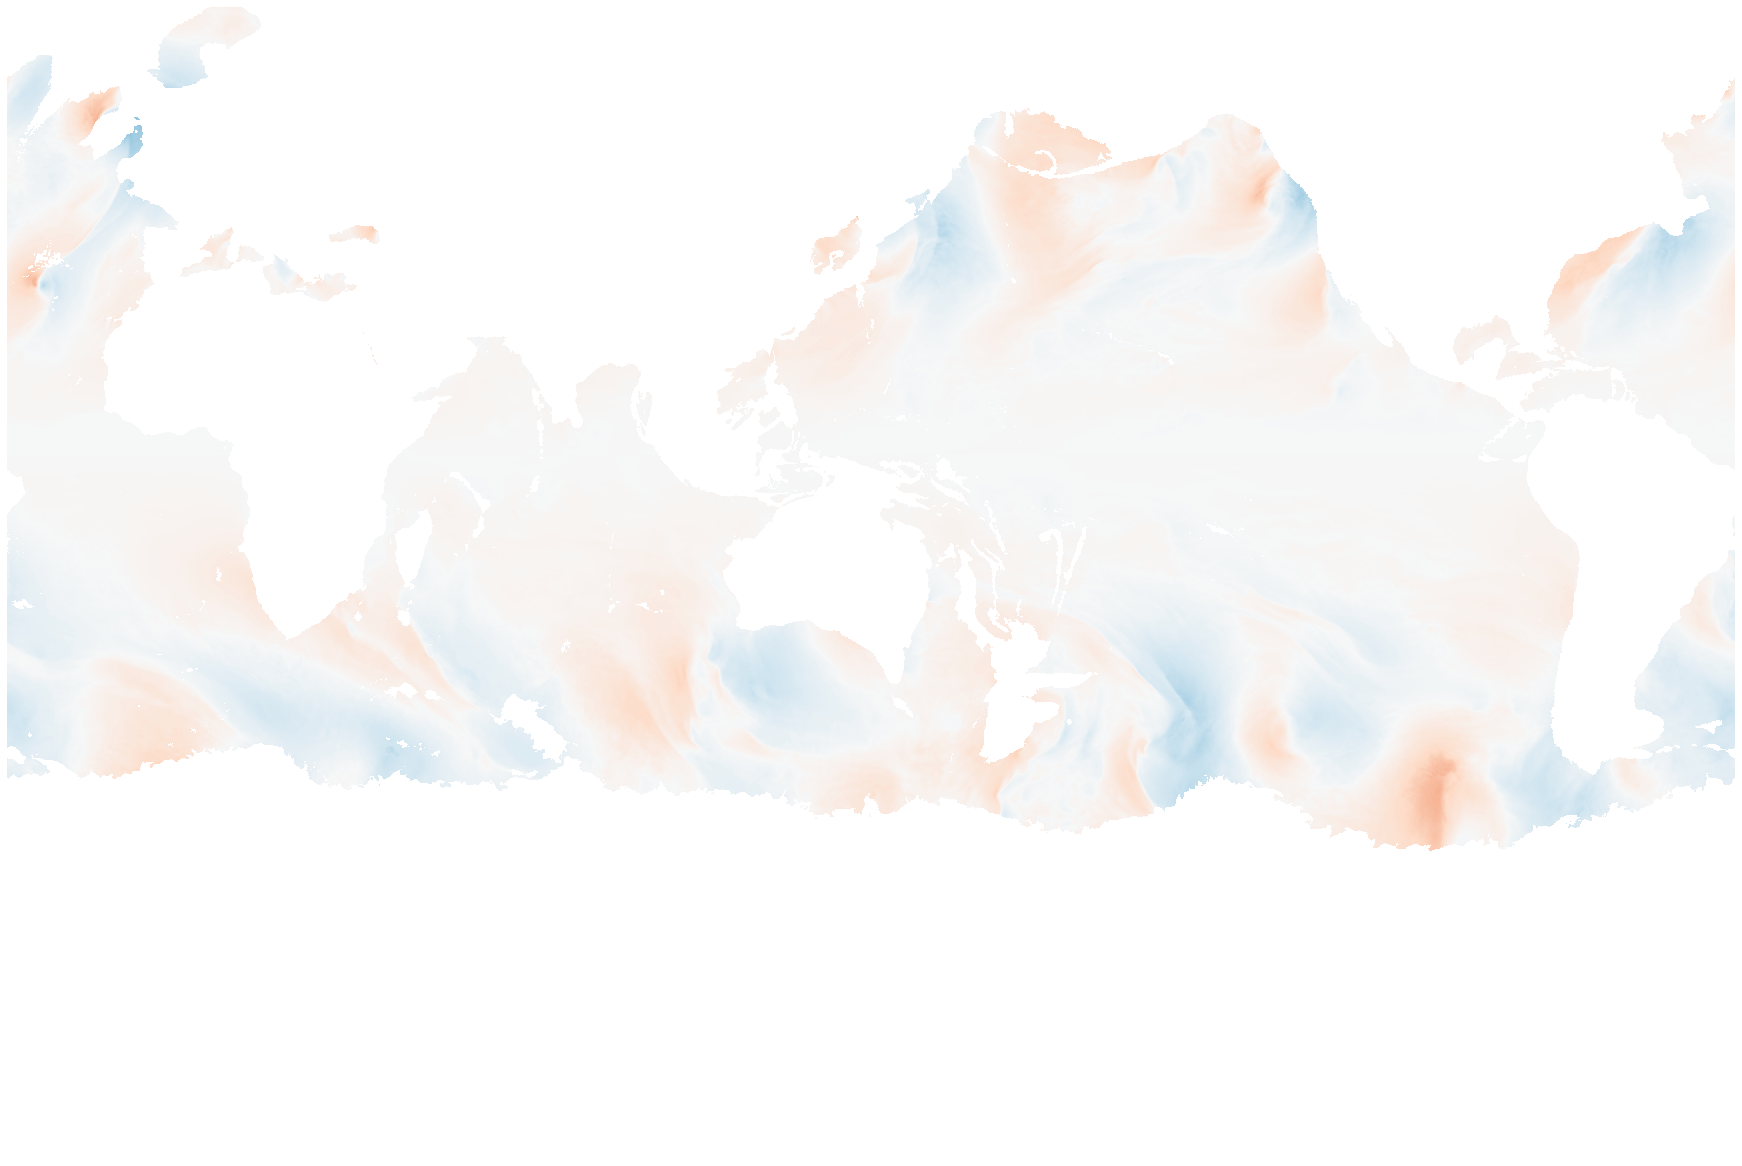

In [23]:
quick_llc_plot(ds_TAUY_ELD_rotation.oceTAUY_H.sel(time='2011-11-24T08:00:00')*(-f_ij)/np.abs(f_ij).where( (ice.AREA>0)&(ds_ELD.Depth>2000) ), vmin=-4e-5, vmax=4e-5, add_colorbar=False, axis_off=True, cmap = 'RdBu_r')

________
## Taux_h = tau_x/(h*rho)

In [5]:
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/TAU/'
ds_TAUX_H  = xr.open_zarr(store_dir_zarr+'TAUX_ELD_rotation_f01.zarr')
ds_TAUX_H

<xarray.Dataset>
Dimensions:    (i: 1080, j: 1080, time: 100)
Coordinates:
    CS         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    Depth      (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    SN         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    XC         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    YC         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    face       int64 ...
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    niter      (time) int64 dask.array<chunksize=(100,), meta=np.ndarray>
    rA         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
  * time       (time) datetime64[ns] 2011-11-23T08:00:00 ... 2011-11-27T11:00:00
Data variables:
    oceTAUX_H  (time, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.n

In [ ]:
Taux_H = ds_TAUX_H.oceTAUX_H.isel(time=1)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

cax = Taux_H.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=-4e-5, vmax=4e-5, cmap = cm.balance, add_colorbar = False)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

plt.ylabel('Latitude',fontsize=16)
plt.xlabel('Longitude',fontsize=16)
ax.tick_params(labelsize=16)

cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Taux_H (m s$^{-2}$)', fontsize=16)

## save movies

In [7]:
ds = ds_TAUX_H.isel(time=slice(0,100))
ds

<xarray.Dataset>
Dimensions:    (i: 1080, j: 1080, time: 100)
Coordinates:
    CS         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    Depth      (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    SN         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    XC         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    YC         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    face       int64 ...
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    niter      (time) int64 dask.array<chunksize=(100,), meta=np.ndarray>
    rA         (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
  * time       (time) datetime64[ns] 2011-11-23T08:00:00 ... 2011-11-27T11:00:00
Data variables:
    oceTAUX_H  (time, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.n

In [8]:


_default_cmaps = {'SSU': cm.balance, 'SSV': cm.balance,
           'SSU_geo': cm.balance, 'SSV_geo': cm.balance,
           'Eta': plt.get_cmap('RdGy_r'), 
           'SST': cm.thermal, 'SSS': cm.haline}

def _get_cmap(v, cmap):
    if cmap is None and v.name in _default_cmaps:
        return _default_cmaps[v.name]
    elif cmap is not None:
        return cmap
    else:
        return plt.get_cmap('magma')

    
    
def plot_scalar(v, colorbar=False, title=None, vmin=None, vmax=None, savefig=None, figsize=(10,10), offline=False, cmap=None):
    #
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        colmap = _get_cmap(v, cmap)
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
        try:
            im = v.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                   x='XC', y='YC', add_colorbar=colorbar, cmap=colmap)
            fig.colorbar(im)
            gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', 
                            alpha=0.5, linestyle='--')
            gl.xlabels_top = False
            if coast_resolution is not None:
                ax.coastlines(resolution=coast_resolution, color='k')
        except:
            pass
        #
        if title is not None:
            ax.set_title(title)
        #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        #if not offline:
        #    plt.show()
        return fig, ax
    
    
face = 1
vmin, vmax = -4e-5, 4e-5

#delete all figures beforehand
figdir = datawork+'others/figs/'

lds = ds

def process(ds, i, overwrite=True):    
    
    Taux_H = ds['oceTAUX_H']
    #print(Taux_H)
    mtime = Taux_H['niter'].values/86400.
    figname = figdir+'Taux_H_f%d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = 'Taux_H %.3f' %mtime
        plot_scalar(Taux_H, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=False, figsize=(15,10))
                    #offline=False, coast_resolution='110m', figsize=(15,10))
        #
        m = float(Taux_H.mean().values)
    else:
        m = -1.
    return m

#I = range(len(ds['time']))
I = range(0,100)
print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]


range(0, 100)


In [9]:
%time results = compute(*values, scheduler='processes')

CPU times: user 13.8 s, sys: 4.7 s, total: 18.5 s
Wall time: 18.6 s


In [11]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
